
# Weather prediction Machine Learning Model based on big data using Hadoop map reduce technique
Predicting rain or weather is a common problem in machine learning. Different machine learning algorithms can be used to model and predict rainfall. In this project, we are asked to complete the analysis to predict whether there will be rain tomorrow or not. In particular, we are required to apply the tools of machine learning to visualize and predict the possibility of rainfall in Australia. 

We must make use of various Technologies as Hive Queries Machine learning technigues as  **Decision Trees, Logistic Regression, Gradient Boosted Machines and Random Forest** to predict whether it will rain tomorrow or not. We shall make use of the various **functions and libraries** within pyspark itself.

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 66.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=593b9c1270adb25ae15e93f4b4d711c9a058a256807407d59080ec21a01254f9
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark





# -*- coding: utf-8 -*-

'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
'''

'''import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()
'''

# Step 1 - Import Spark Session and Initialize Spark

Let's begin with loading all the necessary modules in the system.

- **SparkContext** and **SparkConf** from **pyspark** to create a **Spark Instance**

- **SparkSession** from **pyspark.sql** to work with the **SparkSession**

- **IntegerType and DoubleType** from **pyspark.sql.types** to convert datatypes

- **mean, stddev, col and when** from **pyspark.sql.functions** for stats

- **mode** from **statistics** to calculate the mode

- **StringIndexer and VectorAssembler** from **pyspark.ml.feature** to perform one-hot encoding and making a feature vector

- **LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and GBTClassifier** from **pyspark.ml.classification** for Machine Learning Classifiers

- **Pipeline** from **pyspark.ml** to sequence tasks one in an orderly way

- **MulticlassClassificationEvaluator** from **pyspark.ml.evaluation** to evaluate Machine Learning model's performance

- **MulticlassMetrics** from **pyspark.mllib.evaluation** to get the prediction performance of the model

- **MLUtils** from **pyspark.mllib.util** to support MulticlassMetrics

- **seaborn** for good visuaizations

In [2]:
# loading relevant libraries

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, when
from statistics import mode as _mode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
import seaborn as sns

Create a **Spark session** which will the configuration of our Spark **environment** and a **Spark Context** which will store this config.

Check if the `spark_context` has been created or not. If not, we will initialize the Spark session with the previously defined `spark_context` variable. 

In [3]:
spark_context = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context

if (spark_context is None):
    spark_context = SparkContext(master = "local[4]", appName = "Project")
spark = SparkSession(sparkContext = spark_context)

# Step 2 - Load the Dataset and Print the Schema and Total Number of Entries

Making use of the `spark.read.csv` function, we read in the weather data file. Let's store it in `rain_pred`.

In [5]:
rain_pred = spark.read.csv('weatherAUS.csv', inferSchema = True, header = True)


Let's display the first 10 rows of the dataset to get an idea about the data.

In [6]:
rain_pred.show(10)

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|               Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|

Hmm. Some of the columns contains a lot of NA's that must either be fixed or removed from our dataset. Printing the number of lines in the dataset, we get.

In [8]:
print('Total number of lines in the Weather Australia is : ' + str(rain_pred.count()))

Total number of lines in the Weather Australia is : 142193


# Step 3 - Reduce Columns from the Dataset  

Sometimes, when there are many **NA values in a column**, the best option, keeping that we have a prediction task at hand, is to remove them. Keeping that particular column will only **negatively affect our prediction** and has to go. Therefore, as instructed in the specification, we are dropping the following columns :

- Date
- Location
- Evaporation
- Sunshine
- Cloud9am
- Cloud3pm
- Temp9am
- Temp3pm

In [9]:
rain_pred = rain_pred.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')

Let's inspect to see if they are really gone or not.

In [10]:
rain_pred.show(20)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

In [11]:
rain_pred.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

We have only retained the columns that will be useful to us for making predictions.

# Step 4 - (MAPPER)Print the Number of Missing Data in each Column

In this task, we must display the number of **null values in each column**. As this is something that we will be using on multiple ocassions in our assignment, it only makes sense to make a function, we will call it `missing`.

In [12]:
def missing():
    
    for columns in rain_pred.columns:
        print(columns + ' has number of NULLs : ' + str(rain_pred[rain_pred[columns] == 'NA'].count()))

In [13]:
missing()

MinTemp has number of NULLs : 637
MaxTemp has number of NULLs : 322
Rainfall has number of NULLs : 1406
WindGustDir has number of NULLs : 9330
WindGustSpeed has number of NULLs : 9270
WindDir9am has number of NULLs : 10013
WindDir3pm has number of NULLs : 3778
WindSpeed9am has number of NULLs : 1348
WindSpeed3pm has number of NULLs : 2630
Humidity9am has number of NULLs : 1774
Humidity3pm has number of NULLs : 3610
Pressure9am has number of NULLs : 14014
Pressure3pm has number of NULLs : 13981
RainToday has number of NULLs : 1406
RainTomorrow has number of NULLs : 0


Look at that! We have the count of all the Null values in our dataset. We can now think about how we want to fix them.

# Step 5 - Fill the Missing Data with Average Value and Maximum Occurrence  Value

Here, we are asked to fill the missing values in our dataset. It's simple, if it's a **numerical column**, then we simply replace it with the **average of that column**. If it's a **categorical column**, we replace it by the **maximum frequency value**.

For this task, let's run a loop over all the columns in our dataset to see their datatypes.

In [14]:
for columns in rain_pred.columns:
    
    print('The datatype of ' + str(columns) + ' ' + str(type(columns)))

The datatype of MinTemp <class 'str'>
The datatype of MaxTemp <class 'str'>
The datatype of Rainfall <class 'str'>
The datatype of WindGustDir <class 'str'>
The datatype of WindGustSpeed <class 'str'>
The datatype of WindDir9am <class 'str'>
The datatype of WindDir3pm <class 'str'>
The datatype of WindSpeed9am <class 'str'>
The datatype of WindSpeed3pm <class 'str'>
The datatype of Humidity9am <class 'str'>
The datatype of Humidity3pm <class 'str'>
The datatype of Pressure9am <class 'str'>
The datatype of Pressure3pm <class 'str'>
The datatype of RainToday <class 'str'>
The datatype of RainTomorrow <class 'str'>


Everything is string! Not very helpful, is it? Let's try and calculate the **average** of each column anyway. If it turns out to be a number then we know that column is **numeric**, otherwise it's **categorical**.

In [15]:
for columns in rain_pred.columns:
    print(rain_pred.select(_mean(col(columns))).collect())

[Row(avg(MinTemp)=12.186399728729262)]
[Row(avg(MaxTemp)=23.226784191272476)]
[Row(avg(Rainfall)=2.3499740743109974)]
[Row(avg(WindGustDir)=None)]
[Row(avg(WindGustSpeed)=39.98429165757619)]
[Row(avg(WindDir9am)=None)]
[Row(avg(WindDir3pm)=None)]
[Row(avg(WindSpeed9am)=14.001988000994)]
[Row(avg(WindSpeed3pm)=18.63757586179718)]
[Row(avg(Humidity9am)=68.8438103105705)]
[Row(avg(Humidity3pm)=51.482606091656265)]
[Row(avg(Pressure9am)=1017.6537584159654)]
[Row(avg(Pressure3pm)=1015.2582035379013)]
[Row(avg(RainToday)=None)]
[Row(avg(RainTomorrow)=None)]


## For Numerical Columns

Finding the average of that column and then use that to replace it with the NA's in that column. We shall be making use some query of the `.describe()`, `.collect()`, `.select()`, `.withColumn()`, `when()` and `otherwise()` methods, in a chained format for replacement.

In [16]:
MinTemp_mean = rain_pred.select('MinTemp').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('MinTemp', when(rain_pred['MinTemp'] == 'NA', MinTemp_mean).
                                                                     otherwise(rain_pred['MinTemp']))

In [17]:
MaxTemp_mean = rain_pred.select('MaxTemp').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('MaxTemp', when(rain_pred['MaxTemp'] == 'NA', MaxTemp_mean).
                                                                     otherwise(rain_pred['MaxTemp']))

In [18]:
Rainfall_mean = rain_pred.select('Rainfall').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Rainfall', when(rain_pred['Rainfall'] == 'NA', Rainfall_mean).
                                                                     otherwise(rain_pred['Rainfall']))

In [19]:
WindGustSpeed_mean = rain_pred.select('WindGustSpeed').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindGustSpeed', when(rain_pred['WindGustSpeed'] == 'NA', WindGustSpeed_mean).
                                                                     otherwise(rain_pred['WindGustSpeed']))

In [20]:
WindSpeed9am_mean = rain_pred.select('WindSpeed9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindSpeed9am', when(rain_pred['WindSpeed9am'] == 'NA', WindSpeed9am_mean).
                                                                     otherwise(rain_pred['WindSpeed9am']))

In [21]:
WindSpeed3pm_mean = rain_pred.select('WindSpeed3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindSpeed3pm', when(rain_pred['WindSpeed3pm'] == 'NA', WindSpeed3pm_mean).
                                                                     otherwise(rain_pred['WindSpeed3pm']))

In [22]:
Humidity9am_mean = rain_pred.select('Humidity9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Humidity9am', when(rain_pred['Humidity9am'] == 'NA', Humidity9am_mean).
                                                                     otherwise(rain_pred['Humidity9am']))

In [23]:
Humidity3pm_mean = rain_pred.select('Humidity3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Humidity3pm', when(rain_pred['Humidity3pm'] == 'NA', Humidity3pm_mean).
                                                                     otherwise(rain_pred['Humidity3pm']))

In [24]:
Pressure9am_mean = rain_pred.select('Pressure9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Pressure9am', when(rain_pred['Pressure9am'] == 'NA', Pressure9am_mean).
                                                                     otherwise(rain_pred['Pressure9am']))

In [25]:
Pressure3pm_mean = rain_pred.select('Pressure3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Pressure3pm', when(rain_pred['Pressure3pm'] == 'NA', Pressure3pm_mean).
                                                                     otherwise(rain_pred['Pressure3pm']))

We will call the `missing()` again, which we made earlier instead of writing the code again and again

In [26]:
missing()

MinTemp has number of NULLs : 0
MaxTemp has number of NULLs : 0
Rainfall has number of NULLs : 0
WindGustDir has number of NULLs : 9330
WindGustSpeed has number of NULLs : 0
WindDir9am has number of NULLs : 10013
WindDir3pm has number of NULLs : 3778
WindSpeed9am has number of NULLs : 0
WindSpeed3pm has number of NULLs : 0
Humidity9am has number of NULLs : 0
Humidity3pm has number of NULLs : 0
Pressure9am has number of NULLs : 0
Pressure3pm has number of NULLs : 0
RainToday has number of NULLs : 1406
RainTomorrow has number of NULLs : 0


**No Null values** in the **numerical columns**! Moving on to the **categorical columns**.

## For Categorical Columns Using Hive Commands

Things will be a bit different here, we shall use hive command `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.

In [27]:
rain_pred.groupBy('WindGustDir').count().orderBy('WindGustDir').sort('count', ascending = False).show()

+-----------+-----+
|WindGustDir|count|
+-----------+-----+
|          W| 9780|
|         NA| 9330|
|         SE| 9309|
|          E| 9071|
|          N| 9033|
|        SSE| 8993|
|          S| 8949|
|        WSW| 8901|
|         SW| 8797|
|        SSW| 8610|
|        WNW| 8066|
|         NW| 8003|
|        ENE| 7992|
|        ESE| 7305|
|         NE| 7060|
|        NNW| 6561|
|        NNE| 6433|
+-----------+-----+



In [28]:
rain_pred.groupBy('WindDir9am').count().orderBy('WindDir9am').sort('count', ascending = False).show()

+----------+-----+
|WindDir9am|count|
+----------+-----+
|         N|11393|
|        NA|10013|
|        SE| 9162|
|         E| 9024|
|       SSE| 8966|
|        NW| 8552|
|         S| 8493|
|         W| 8260|
|        SW| 8237|
|       NNE| 7948|
|       NNW| 7840|
|       ENE| 7735|
|       ESE| 7558|
|        NE| 7527|
|       SSW| 7448|
|       WNW| 7194|
|       WSW| 6843|
+----------+-----+



In [29]:
rain_pred.groupBy('WindDir3pm').count().orderBy('WindDir3pm').sort('count', ascending = False).show()

+----------+-----+
|WindDir3pm|count|
+----------+-----+
|        SE|10663|
|         W| 9911|
|         S| 9598|
|       WSW| 9329|
|        SW| 9182|
|       SSE| 9142|
|         N| 8667|
|       WNW| 8656|
|        NW| 8468|
|       ESE| 8382|
|         E| 8342|
|        NE| 8164|
|       SSW| 8010|
|       NNW| 7733|
|       ENE| 7724|
|       NNE| 6444|
|        NA| 3778|
+----------+-----+



In [30]:
rain_pred.groupBy('RainToday').count().orderBy('RainToday').sort('count', ascending = False).show()

+---------+------+
|RainToday| count|
+---------+------+
|       No|109332|
|      Yes| 31455|
|       NA|  1406|
+---------+------+



In [31]:
rain_pred.groupBy('MinTemp').count().orderBy('MinTemp').sort('count', ascending = False).show()

+-------+-----+
|MinTemp|count|
+-------+-----+
|     11|  883|
|    9.6|  883|
|   10.2|  880|
|   10.5|  867|
|   10.8|  860|
|      9|  853|
|     12|  850|
|     10|  849|
|     13|  844|
|    8.9|  842|
|   10.4|  842|
|    9.7|  836|
|   11.5|  835|
|    8.5|  833|
|   11.3|  831|
|   11.8|  827|
|   12.7|  827|
|   10.9|  822|
|   11.4|  820|
|   12.4|  815|
+-------+-----+
only showing top 20 rows



In [32]:
rain_pred.groupBy('MaxTemp').count().orderBy('MaxTemp').sort('count', ascending = False).show()

+-------+-----+
|MaxTemp|count|
+-------+-----+
|     20|  871|
|   19.8|  829|
|     19|  827|
|   20.4|  820|
|   20.8|  804|
|   19.9|  803|
|   19.5|  801|
|     21|  799|
|   18.5|  793|
|   18.2|  792|
|   19.4|  790|
|   18.9|  789|
|   21.2|  787|
|   19.6|  785|
|   20.2|  785|
|   18.8|  776|
|     18|  771|
|     25|  770|
|   22.2|  769|
|   20.1|  765|
+-------+-----+
only showing top 20 rows



In [33]:
rain_pred.groupBy('Rainfall').count().orderBy('Rainfall').sort('count', ascending = False).show()

+------------------+-----+
|          Rainfall|count|
+------------------+-----+
|                 0|90275|
|               0.2| 8685|
|               0.4| 3750|
|               0.6| 2562|
|               0.8| 2028|
|                 1| 1747|
|               1.2| 1515|
|2.3499740743109974| 1406|
|               1.4| 1365|
|               1.6| 1187|
|               1.8| 1088|
|                 2| 1024|
|               2.2|  973|
|               2.4|  835|
|               2.6|  831|
|               2.8|  723|
|                 3|  706|
|               3.2|  662|
|               3.4|  602|
|               3.8|  590|
+------------------+-----+
only showing top 20 rows



In [34]:
rain_pred.groupBy('WindGustSpeed').count().orderBy('WindGustSpeed').sort('count', ascending = False).show()

+-----------------+-----+
|    WindGustSpeed|count|
+-----------------+-----+
|39.98429165757619| 9270|
|               35| 9070|
|               39| 8656|
|               31| 8310|
|               37| 7903|
|               33| 7814|
|               41| 7236|
|               30| 6943|
|               43| 6513|
|               28| 6382|
|               44| 5341|
|               46| 5308|
|               48| 4979|
|               50| 4806|
|               26| 4791|
|               24| 4125|
|               52| 3747|
|               54| 3404|
|               22| 2787|
|               20| 2598|
+-----------------+-----+
only showing top 20 rows



In [35]:
rain_pred.groupBy('WindSpeed9am').count().orderBy('WindSpeed9am').sort('count', ascending = False).show()

+---------------+-----+
|   WindSpeed9am|count|
+---------------+-----+
|              9|13400|
|             13|12851|
|             11|11514|
|             17|10599|
|              7|10587|
|             15|10396|
|              6| 8989|
|              0| 8612|
|             19| 8579|
|             20| 7904|
|              4| 6292|
|             22| 5541|
|             24| 5317|
|              2| 4544|
|             26| 3669|
|             28| 3483|
|             30| 2255|
|             31| 1961|
|14.001988000994| 1348|
|             33| 1098|
+---------------+-----+
only showing top 20 rows



In [36]:
rain_pred.groupBy('Humidity9am').count().orderBy('Humidity9am').sort('count', ascending = False).show()

+-----------+-----+
|Humidity9am|count|
+-----------+-----+
|         99| 3350|
|         70| 2985|
|         69| 2962|
|         68| 2961|
|         65| 2952|
|         71| 2939|
|         66| 2916|
|         67| 2895|
|         64| 2867|
|         75| 2859|
|         72| 2859|
|         74| 2857|
|        100| 2827|
|         73| 2823|
|         76| 2761|
|         63| 2699|
|         62| 2697|
|         61| 2623|
|         77| 2603|
|         78| 2576|
+-----------+-----+
only showing top 20 rows



In [37]:
rain_pred.groupBy('Pressure9am').count().orderBy('Pressure9am').sort('count', ascending = False).show()

+------------------+-----+
|       Pressure9am|count|
+------------------+-----+
|1017.6537584159654|14014|
|            1016.4|  804|
|            1017.9|  779|
|            1018.7|  764|
|              1018|  761|
|            1015.9|  757|
|            1017.3|  756|
|            1017.8|  755|
|            1016.3|  753|
|            1017.2|  745|
|            1015.5|  744|
|            1017.7|  744|
|            1017.6|  743|
|            1016.9|  742|
|            1017.5|  738|
|            1018.2|  737|
|            1019.6|  735|
|            1018.1|  734|
|            1015.7|  731|
|            1019.4|  728|
+------------------+-----+
only showing top 20 rows



In [38]:
rain_pred.groupBy('Pressure3pm').count().orderBy('Pressure3pm').sort('count', ascending = False).show()

+------------------+-----+
|       Pressure3pm|count|
+------------------+-----+
|1015.2582035379013|13981|
|            1015.5|  773|
|            1015.3|  767|
|            1015.7|  763|
|            1015.6|  761|
|            1015.1|  752|
|            1015.8|  751|
|            1013.5|  751|
|            1015.4|  745|
|              1016|  738|
|            1014.8|  735|
|            1015.2|  730|
|            1014.9|  727|
|            1013.4|  723|
|            1016.5|  719|
|            1013.7|  717|
|            1013.3|  717|
|            1014.2|  716|
|            1017.1|  715|
|            1013.8|  711|
+------------------+-----+
only showing top 20 rows



In [39]:
rain_pred.groupBy('RainTomorrow').count().orderBy('RainTomorrow').sort('count', ascending = False).show()

+------------+------+
|RainTomorrow| count|
+------------+------+
|          No|110316|
|         Yes| 31877|
+------------+------+



In [41]:

rain_pred.sort(col("MinTemp"),col("Rainfall")).show(truncate=False)


+-------+-------+--------+-----------+-----------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed    |WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am       |Pressure3pm       |RainToday|RainTomorrow|
+-------+-------+--------+-----------+-----------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+---------+------------+
|-0.1   |14.5   |0       |NE         |20               |NA        |ENE       |0           |13          |74         |45         |1034.5            |1030.9            |No       |No          |
|-0.1   |19.7   |0       |NA         |39.98429165757619|NNW       |WNW       |11          |26          |60         |34         |1026.5            |1021.7            |No       |No          |
|-0.1   |10.2   |0       |SE         |22          

In [42]:

rain_pred.orderBy("Rainfall","WindGustDir").show(truncate=False)


+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|20.3   |28.4   |0       |E          |44           |ESE       |E         |19          |30          |64         |55         |1020.1     |1017.1     |No       |No          |
|23.4   |30.4   |0       |E          |33           |E         |NE        |20          |19          |60         |42         |1016.7     |1012.8     |No       |No          |
|18.9   |28.3   |0       |E          |43           |SE        |E         |13          |30          |66         |62         |1019.1     |1015

In [43]:
rain_pred.sort(col("Humidity9am").asc(),col("RainTomorrow").desc()).show(truncate=False)

+-------+-------+--------+-----------+-----------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed    |WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-----------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|19.4   |40     |0       |NNW        |61               |N         |N         |28          |33          |0          |0          |1011.7     |1007.6     |No       |No          |
|20.9   |41.1   |0       |SSW        |52               |NW        |NW        |24          |11          |1          |2          |1010       |1005.4     |No       |No          |
|14.6   |19.1   |9.8     |SSW        |50               |SW        |S         |22          |24          |1          |1   

Here, we shall make use of the `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.



In [ ]:
WindGustDir_mode = rain_pred.groupBy('WindGustDir').count().orderBy('WindGustDir').sort('count', ascending = False).collect()[0][0]
WindGustDir_mode

'W'

In [ ]:
WindDir9am_mode = rain_pred.groupBy('WindDir9am').count().orderBy('WindDir9am').sort('count', ascending = False).collect()[0][0]
WindDir9am_mode

'N'

In [ ]:
WindDir3pm_mode = rain_pred.groupBy('WindDir3pm').count().orderBy('WindDir3pm').sort('count', ascending = False).collect()[0][0]
WindDir3pm_mode

'SE'

In [ ]:
RainToday_mode = rain_pred.groupBy('RainToday').count().orderBy('RainToday').sort('count', ascending = False).collect()[0][0]
RainToday_mode

'No'

Ssing a similar syntaxt to replace the actual null values in the dataset.

In [ ]:
rain_pred = rain_pred.withColumn('WindGustDir', when(rain_pred['WindGustDir'] == 'NA', WindGustDir_mode).
                                                                     otherwise(rain_pred['WindGustDir']))

In [ ]:
rain_pred = rain_pred.withColumn('WindDir9am', when(rain_pred['WindDir9am'] == 'NA', WindDir9am_mode).
                                                                     otherwise(rain_pred['WindDir9am']))

In [ ]:
rain_pred = rain_pred.withColumn('WindDir3pm', when(rain_pred['WindDir3pm'] == 'NA', WindDir3pm_mode).
                                                                     otherwise(rain_pred['WindDir3pm']))

In [ ]:
rain_pred = rain_pred.withColumn('RainToday', when(rain_pred['RainToday'] == 'NA', RainToday_mode).
                                                                     otherwise(rain_pred['RainToday']))

Let's call our function, the `missing()` to get the number of nulls in the dataset.

In [ ]:
missing()

MinTemp has number of NULLs : 0
MaxTemp has number of NULLs : 0
Rainfall has number of NULLs : 0
WindGustDir has number of NULLs : 0
WindGustSpeed has number of NULLs : 0
WindDir9am has number of NULLs : 0
WindDir3pm has number of NULLs : 0
WindSpeed9am has number of NULLs : 0
WindSpeed3pm has number of NULLs : 0
Humidity9am has number of NULLs : 0
Humidity3pm has number of NULLs : 0
Pressure9am has number of NULLs : 0
Pressure3pm has number of NULLs : 0
RainToday has number of NULLs : 0
RainTomorrow has number of NULLs : 0


All nulls are gone! We can now move on to some basic datatype transformations which we can directly feed into the Machine Learning algorithm.

# Step 6 - Data Transformation

Machine Learning Algorithms, often except only **numerical columns** as input and would throw an error if supplied with **categorical** variables. Hence, we need to convert the numerical columns from **string** to **double** and convert categorical columns from **string** to **numbers** that the algorithm can directly use to process.

Making a list of numerical columns and name it `numerical_list`. Looping over the numerical_list, we use `cast(DoubleType())` to convert it from **string** to **double**.

In [ ]:
numerical_list = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm']

In [ ]:
for columns in numerical_list:
    rain_pred = rain_pred.withColumn(columns, rain_pred[columns].cast(DoubleType()))

Let's inspect if it changed or not.

In [ ]:
rain_pred.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



For categorical columns, we make a list named `categorical_list`, loop over it and use the `StringIndexer()` method, call the `Pipeline()` method on it and finally use the `.fit()` to fit it to the dataset.

In [ ]:
categorical_list = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [ ]:
indexers = [StringIndexer(inputCol = column, outputCol = column + "_index").fit(rain_pred) for column in categorical_list]


pipeline = Pipeline(stages = indexers)
rain_pred_indexers = pipeline.fit(rain_pred).transform(rain_pred)

rain_pred_indexers.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|              0.0|             6.0|             7.0|

In [ ]:
drop = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

rain_pred_indexers = rain_pred_indexers.drop(*drop)

rain_pred_indexers.show(10)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|              0.0|             6.0|             7.0|            0.0|               0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|              9.0|             9.0|             3.0|            0.0|          

# Step 7 - Create the Feature Vector and Divide the Dataset

Here, we are required to use the `VectorAssembler()` to convert the set of features into a **feature vector**.

In [ ]:
target = ['RainTomorrow_index']

assembler = VectorAssembler(
    inputCols = [columns for columns in rain_pred_indexers.columns if columns not in target],
    outputCol = 'feature_vector')

rain_pred_indexers_data = assembler.transform(rain_pred_indexers) # converting the whole row to a vector except
                                                                  # the target variable

In [ ]:
rain_pred_indexers_data.show(10)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|      feature_vector|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|              0.0|             6.0|             7.0|            0.0|               0.0|[13.4,22.9,0.6,44...|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1



Now we have everything we need to train our model and get predictions. Let's split our data into training and test set with 70:30 ratio respectively.

In [ ]:
rain_test, rain_train = rain_pred_indexers_data.randomSplit([0.3, 0.7], seed = 123)

In [ ]:
rain_test.count()

43043

In [ ]:
rain_train.count()

99150

# Step 8 - Apply Machine Learning Classification Algorithms on the Dataset and Compare their Accuracy. Plot the Accuracy as Bar Graph


Start with Decision Trees. Using the `DecisionTreeClassifier()` and `.fit()` method on our training data.

# Decision Trees

In [ ]:
DT_Classifier = DecisionTreeClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector')
DT_Model = DT_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [ ]:
DT_Prediction = DT_Model.transform(rain_test)

Print out the predictions that the model made.

In [ ]:
DT_Prediction.head(5)

[Row(MinTemp=-3.3, MaxTemp=22.2, Rainfall=0.0, WindGustSpeed=30.0, WindSpeed9am=0.0, WindSpeed3pm=13.0, Humidity9am=90.0, Humidity3pm=24.0, Pressure9am=1021.7, Pressure3pm=1016.2, WindGustDir_index=0.0, WindDir9am_index=0.0, WindDir3pm_index=7.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 22.2, 0.0, 30.0, 0.0, 13.0, 90.0, 24.0, 1021.7, 1016.2, 0.0, 0.0, 7.0, 0.0]), rawPrediction=DenseVector([43617.0, 3814.0]), probability=DenseVector([0.9196, 0.0804]), prediction=0.0),
 Row(MinTemp=-3.1, MaxTemp=12.4, Rainfall=0.0, WindGustSpeed=13.0, WindSpeed9am=6.0, WindSpeed3pm=2.0, Humidity9am=69.0, Humidity3pm=60.0, Pressure9am=1029.2, Pressure3pm=1027.3, WindGustDir_index=13.0, WindDir9am_index=12.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.1, 12.4, 0.0, 13.0, 6.0, 2.0, 69.0, 60.0, 1029.2, 1027.3, 13.0, 12.0, 3.0, 0.0]), rawPrediction=DenseVector([24284.0, 5814.0]), probability=DenseVector([0.8068, 0.193

let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [ ]:
DT_Evaluator = MulticlassClassificationEvaluator(labelCol =  'RainTomorrow_index', predictionCol = 'prediction')

In [ ]:
DT_Accuracy = DT_Evaluator.evaluate(DT_Prediction)

In [ ]:
print('Decision Tree Accuracy is : ' + str(DT_Accuracy * 100))
print('Test Error is : ' + str(1 - DT_Accuracy))

Decision Tree Accuracy is : 81.61852942022482
Test Error is : 0.18381470579775183


Next we have Random Forest.

# Random Forest

We shall now build Random Forest. Using the `RandomForestClassifier()` and `.fit()` method on our training data.

In [ ]:
RF_Classifier = RandomForestClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector',  maxDepth = 5,
    maxBins = 32, numTrees = 500)

RF_Model = RF_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [ ]:
RF_Prediction = RF_Model.transform(rain_test)

In [ ]:
RF_Prediction.head(5)

[Row(MinTemp=-3.3, MaxTemp=22.2, Rainfall=0.0, WindGustSpeed=30.0, WindSpeed9am=0.0, WindSpeed3pm=13.0, Humidity9am=90.0, Humidity3pm=24.0, Pressure9am=1021.7, Pressure3pm=1016.2, WindGustDir_index=0.0, WindDir9am_index=0.0, WindDir3pm_index=7.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 22.2, 0.0, 30.0, 0.0, 13.0, 90.0, 24.0, 1021.7, 1016.2, 0.0, 0.0, 7.0, 0.0]), rawPrediction=DenseVector([440.2649, 59.7351]), probability=DenseVector([0.8805, 0.1195]), prediction=0.0),
 Row(MinTemp=-3.1, MaxTemp=12.4, Rainfall=0.0, WindGustSpeed=13.0, WindSpeed9am=6.0, WindSpeed3pm=2.0, Humidity9am=69.0, Humidity3pm=60.0, Pressure9am=1029.2, Pressure3pm=1027.3, WindGustDir_index=13.0, WindDir9am_index=12.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.1, 12.4, 0.0, 13.0, 6.0, 2.0, 69.0, 60.0, 1029.2, 1027.3, 13.0, 12.0, 3.0, 0.0]), rawPrediction=DenseVector([440.203, 59.797]), probability=DenseVector([0.8804, 0.1


let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [ ]:
RF_Evaluator = MulticlassClassificationEvaluator(labelCol = 'RainTomorrow_index', predictionCol = 'prediction')

In [ ]:
RF_Accuracy = RF_Evaluator.evaluate(RF_Prediction)

In [ ]:
print('Random Forest Accuracy is : ' + str(RF_Accuracy * 100))
print('Test Error is : ' + str(1 - RF_Accuracy))

Random Forest Accuracy is : 81.27162310981645
Test Error is : 0.1872837689018355


More or less the same perfomance as Decision Tree's. In that case, we would prefer Decision Trees over Random Forest becasue it's **faster** and **more interpretable**.

# Gradient Boosted Tree

We shall now build Gradient Boosted Machines. Using the `GBTClassifier()` and `.fit()` method on our training data.

In [ ]:
GBT_Classifier = GBTClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector', maxIter = 20, maxDepth = 5, 
                               maxBins = 32)

In [ ]:
GBT_Model = GBT_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [ ]:
GBT_Prediction = GBT_Model.transform(rain_test)

In [ ]:
GBT_Prediction.head(5)

[Row(MinTemp=-3.3, MaxTemp=22.2, Rainfall=0.0, WindGustSpeed=30.0, WindSpeed9am=0.0, WindSpeed3pm=13.0, Humidity9am=90.0, Humidity3pm=24.0, Pressure9am=1021.7, Pressure3pm=1016.2, WindGustDir_index=0.0, WindDir9am_index=0.0, WindDir3pm_index=7.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 22.2, 0.0, 30.0, 0.0, 13.0, 90.0, 24.0, 1021.7, 1016.2, 0.0, 0.0, 7.0, 0.0]), rawPrediction=DenseVector([1.3648, -1.3648]), probability=DenseVector([0.9388, 0.0612]), prediction=0.0),
 Row(MinTemp=-3.1, MaxTemp=12.4, Rainfall=0.0, WindGustSpeed=13.0, WindSpeed9am=6.0, WindSpeed3pm=2.0, Humidity9am=69.0, Humidity3pm=60.0, Pressure9am=1029.2, Pressure3pm=1027.3, WindGustDir_index=13.0, WindDir9am_index=12.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.1, 12.4, 0.0, 13.0, 6.0, 2.0, 69.0, 60.0, 1029.2, 1027.3, 13.0, 12.0, 3.0, 0.0]), rawPrediction=DenseVector([1.1724, -1.1724]), probability=DenseVector([0.9125, 0.087

Interesting predictions, let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [ ]:
GBT_Evaluator = MulticlassClassificationEvaluator(labelCol = 'RainTomorrow_index', predictionCol = 'prediction')

In [ ]:
GBT_Accuracy = GBT_Evaluator.evaluate(GBT_Prediction)

In [ ]:
print('GBT Accuracy is : ' + str(GBT_Accuracy * 100))
print('Test Error is : ' + str(1 - GBT_Accuracy))

GBT Accuracy is : 82.90374067314038
Test Error is : 0.1709625932685962


Better performance than both Decision Trees and Random Forest! But not by much. Onwards we go to our last algorithm, Logistic Regression.

# Logistic Regression

We shall now build Logistic Regression model. Using the `LogisticRegression()` and `.fit()` method on our training data.

In [ ]:
LogReg_Classifier = LogisticRegression(regParam = 0.3, labelCol = "RainTomorrow_index", featuresCol = 'feature_vector', \
                                       maxIter = 20,  elasticNetParam = 0.8)

In [ ]:
LogReg_Model = LogReg_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [ ]:
LogReg_Prediction = LogReg_Model.transform(rain_test)

LogReg_Prediction.head(5)

[Row(MinTemp=-3.3, MaxTemp=22.2, Rainfall=0.0, WindGustSpeed=30.0, WindSpeed9am=0.0, WindSpeed3pm=13.0, Humidity9am=90.0, Humidity3pm=24.0, Pressure9am=1021.7, Pressure3pm=1016.2, WindGustDir_index=0.0, WindDir9am_index=0.0, WindDir3pm_index=7.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 22.2, 0.0, 30.0, 0.0, 13.0, 90.0, 24.0, 1021.7, 1016.2, 0.0, 0.0, 7.0, 0.0]), rawPrediction=DenseVector([1.2414, -1.2414]), probability=DenseVector([0.7758, 0.2242]), prediction=0.0),
 Row(MinTemp=-3.1, MaxTemp=12.4, Rainfall=0.0, WindGustSpeed=13.0, WindSpeed9am=6.0, WindSpeed3pm=2.0, Humidity9am=69.0, Humidity3pm=60.0, Pressure9am=1029.2, Pressure3pm=1027.3, WindGustDir_index=13.0, WindDir9am_index=12.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.1, 12.4, 0.0, 13.0, 6.0, 2.0, 69.0, 60.0, 1029.2, 1027.3, 13.0, 12.0, 3.0, 0.0]), rawPrediction=DenseVector([1.2414, -1.2414]), probability=DenseVector([0.7758, 0.224

Let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [ ]:
LogReg_Evaluator = MulticlassClassificationEvaluator(labelCol = "RainTomorrow_index", predictionCol = "prediction", \
                                                     metricName = "accuracy")

In [ ]:
LogReg_Accuracy = LogReg_Evaluator.evaluate(LogReg_Prediction)

In [ ]:
print('Logistic Regression Accuracy is : ' + str(LogReg_Accuracy * 100))
print('Test Error is : ' + str(1 - LogReg_Accuracy))

Logistic Regression Accuracy is : 77.58288223404503
Test Error is : 0.22417117765954975


Logistic Regression seems to be doing just okay as compared to our other algorithms. Let's get into more model performace indicators like Confusion Matrix, Recall, Precision, F1 Score etc.

Now, let's get a sense of all prediction accuracies by visualizing them. We could perhaps, use a bar chart for it.

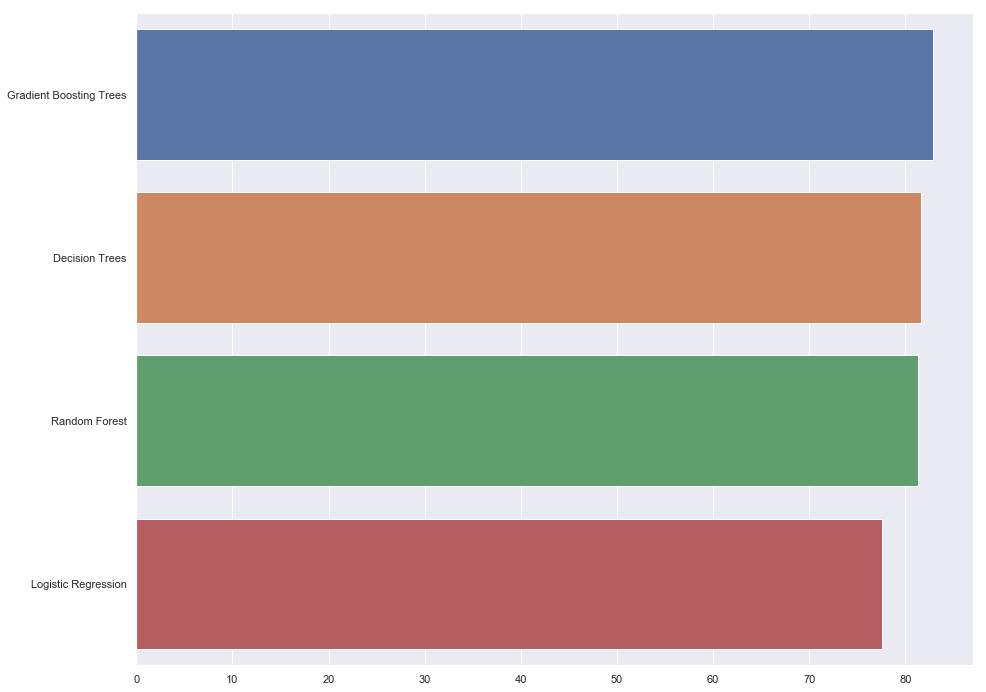

In [ ]:
sns.set(rc = {'figure.figsize':(15, 12)})

model_classifiers = ['Gradient Boosting Trees', 'Decision Trees', 'Random Forest', 'Logistic Regression']

model_accuracies = [GBT_Accuracy * 100, DT_Accuracy * 100, RF_Accuracy * 100, LogReg_Accuracy * 100]

sns.barplot(y = model_classifiers, x = model_accuracies)

# Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved? 

## GBT Model Performance

For this task, we must make a **Confusion Matrix**, find the **Precision, Recall and F1-Score** for all the algorithms.

We will be making use of built-in functions such as `MulticlassMetrics()`, `confusionMatrix()` for this task. For the other metrics like Precision, Recall and F1-Score, we can calculate them by **manipulating the confusion matrix**.

As we will repeat the same for everything, there's no need to repeat the documentation for everything.

In [ ]:
GBT_Prediction_Labels = GBT_Prediction.select(['prediction', 'RainTomorrow_index'])

GBT_KPI = MulticlassMetrics(GBT_Prediction_Labels.rdd.map(list))

In [ ]:
GBT_confusion_matrix = GBT_KPI.confusionMatrix().toArray()

print('GBT Confusion Matrix')

print(GBT_confusion_matrix)

GBT Confusion Matrix
[[31788.  1606.]
 [ 5160.  4489.]]


In [ ]:
GBT_precision = (GBT_confusion_matrix[0][0]) / (GBT_confusion_matrix[0][0] + GBT_confusion_matrix[1][0])
print('GBT Precision = ' + str(GBT_precision))

GBT Precision = 0.8603442676193569


In [ ]:
GBT_recall = (GBT_confusion_matrix[0][0]) / (GBT_confusion_matrix[0][0] + GBT_confusion_matrix[0][1])
print('GBT Recall = ' + str(GBT_recall))

GBT Recall = 0.9519075282984968


In [ ]:
GBT_f1Score = (GBT_precision * GBT_recall) / (GBT_precision + GBT_recall) * 2
print('GBT F1 Score = ' + str(GBT_f1Score))

GBT F1 Score = 0.9038128003184441


## Decision Trees Model Performance

In [ ]:
DT_Prediction_Labels = DT_Prediction.select(['prediction', 'RainTomorrow_index'])

DT_KPI = MulticlassMetrics(DT_Prediction_Labels.rdd.map(list))

In [ ]:
DT_confusion_matrix = DT_KPI.confusionMatrix().toArray()

print('DT Confusion Matrix')

print(DT_confusion_matrix)

DT Confusion Matrix
[[32153.  1241.]
 [ 5805.  3844.]]


In [ ]:
DT_precision = (DT_confusion_matrix[0][0]) / (DT_confusion_matrix[0][0] + DT_confusion_matrix[1][0])
print('DT Precision = ' + str(DT_precision))

DT Precision = 0.8470678117919807


In [ ]:
DT_recall = (DT_confusion_matrix[0][0]) / (DT_confusion_matrix[0][0] + DT_confusion_matrix[0][1])
print('DT Recall = ' + str(DT_recall))

DT Recall = 0.9628376355033839


In [ ]:
DT_f1Score = (DT_precision * DT_recall) / (DT_precision + DT_recall) * 2
print('DT F1 Score = ' + str(DT_f1Score))

DT F1 Score = 0.9012501401502411


## Random Forest Model Performance

In [ ]:
RF_Prediction_Labels = RF_Prediction.select(['prediction', 'RainTomorrow_index'])

RF_KPI = MulticlassMetrics(RF_Prediction_Labels.rdd.map(list))

In [ ]:
RF_confusion_matrix = RF_KPI.confusionMatrix().toArray()

print('RF Confusion Matrix')

print(RF_confusion_matrix)

RF Confusion Matrix
[[32309.  1085.]
 [ 6006.  3643.]]


In [ ]:
RF_precision = (RF_confusion_matrix[0][0]) / (RF_confusion_matrix[0][0] + RF_confusion_matrix[1][0])
print('RF Precision = ' + str(RF_precision))

RF Precision = 0.8432467701944408


In [ ]:
RF_recall = (RF_confusion_matrix[0][0]) / (RF_confusion_matrix[0][0] + RF_confusion_matrix[0][1])
print('RF Recall = ' + str(RF_recall))

RF Recall = 0.9675091333772534


In [ ]:
RF_f1Score = (RF_precision * RF_recall) / (RF_precision + RF_recall) * 2
print('RF F1 Score = ' + str(RF_f1Score))

RF F1 Score = 0.9011142255504888


## Logistic Regression Model Performance

In [ ]:
LogReg_Prediction_Labels = LogReg_Prediction.select(['prediction', 'RainTomorrow_index'])

LogReg_KPI = MulticlassMetrics(LogReg_Prediction_Labels.rdd.map(list))

In [ ]:
LogReg_confusion_matrix = LogReg_KPI.confusionMatrix().toArray()

print('LogReg Confusion Matrix')

print(LogReg_confusion_matrix)

LogReg Confusion Matrix
[[33394.     0.]
 [ 9649.     0.]]


In [ ]:
LogReg_precision = (LogReg_confusion_matrix[0][0]) / (LogReg_confusion_matrix[0][0] + LogReg_confusion_matrix[1][0])
print('LogReg Precision = ' + str(LogReg_precision))

LogReg Precision = 0.7758288223404503


In [ ]:
LogReg_recall = (LogReg_confusion_matrix[0][0]) / (LogReg_confusion_matrix[0][0] + LogReg_confusion_matrix[0][1])
print('LogReg Recall = ' + str(LogReg_recall))

LogReg Recall = 1.0


In [ ]:
LogReg_f1Score = (LogReg_precision * LogReg_recall) / (LogReg_precision + LogReg_recall) * 2
print('LogReg F1 Score = ' + str(LogReg_f1Score))

LogReg F1 Score = 0.8737653230765206


## How can we Improve the Accuracy?

We are aware that no single machine learning algorithm can reliably anticipate outcomes for every issue.
For instance, SVM (Support Vector Machine) could perform mediocrely while solving regression problems, but excels in text classification issues.
The "No Free Lunch" theorem refers to this.
As a result, the only way to find the optimum method for the problem is by trial and error with several algorithms.

There are two other ways which come to mind when we think about increasing the accuracy of the model :

1) **Hyperparameter tuning** is the process of tweaking and altering a set of parameters while measuring accuracy against it to determine the best set for a given problem.
Using **grid search,** which essentially uses a wide range of parameters for tweaking until the best set of parameters is identified," we can automate this. 

2. **Dealing with Highly Imbalanced Data**The initial Yes:No ratio in the training set is approximately 1:4, which is severely unbalanced because the class **Yes** label is much underrepresented compared to the class **No** label in this issue of predicting the RainTomorrow label.This may have an impact on the final model's prediction probability.Methods like **Prior Probability**, **Weighted Matrix**, etc. can be used to deal with this. 